# CardioGoodFitness

Статистический анализ данных. Цель выявить типичного пользователя беговой дорожки, а также выяснить отличаются ли пользователи, предпочитающие разные типы беговых дорожек.

## Описание данных 

- Product - тип продукта 
- Age - возраст в годах
- Gender - пол
- Education - образование в годах 
- MaritalStatus - семейный статус 
- Usage - планируют использовать (часы в неделю)
- Fitness - самооценка физической формы по шкале от 1 до 5, где 1 - плохая форма, а 5 - отличная форма. 
- Income - годовой доход
- Miles - планируют пробегать в неделю 

## Подключение библиотек 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plot

## Статистический анализ 

In [2]:
data = pd.read_csv('/datasets/Kaggle/CardioGoodFitness.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product        180 non-null    object
 1   Age            180 non-null    int64 
 2   Gender         180 non-null    object
 3   Education      180 non-null    int64 
 4   MaritalStatus  180 non-null    object
 5   Usage          180 non-null    int64 
 6   Fitness        180 non-null    int64 
 7   Income         180 non-null    int64 
 8   Miles          180 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 12.8+ KB


In [4]:
data.head()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,TM195,18,Male,14,Single,3,4,29562,112
1,TM195,19,Male,15,Single,2,3,31836,75
2,TM195,19,Female,14,Partnered,4,3,30699,66
3,TM195,19,Male,12,Single,3,3,32973,85
4,TM195,20,Male,13,Partnered,4,2,35247,47


### Вывод

Данные не содержат пустых значений 

### Поле Age

In [ ]:
fig = plot.figure(figsize=(20, 10))
ax1 = plot.subplot2grid((2, 2), (0, 0))
sns.histplot(data, x="Age", ax=ax1).set_title('Гистограмма возраста')

ax1 = plot.subplot2grid((2, 2), (0, 1))
sns.histplot(data, x="Age",  stat="density", ax=ax1).set_title('Плотность распределения')

ax1 = plot.subplot2grid((2, 2), (1, 0), colspan=2)
sns.boxplot(x=data['Age'], ax=ax1, orient='h').set(
    title='Диаграмма размаха',  
    xlabel='Возраст', 
    ylabel=''
)
plot.show()

Распределение содержит небольшое количества выбросов после 45 лет (не многие люди бегают после этого возраста) и предположительно имеет лог-нормальное. Проверим наше предположение.

#### Тестирование поля Age на лог-нормальное распределения 

In [6]:
tmp = data[data['Age'] < 47]

/home/alex/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


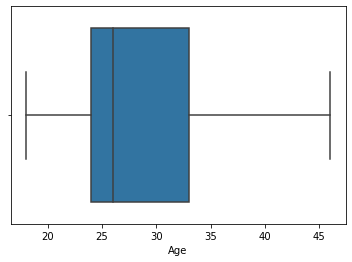

In [7]:
sns.boxplot(tmp['Age'])
plot.show()

In [8]:
tmp = np.log(tmp['Age'])

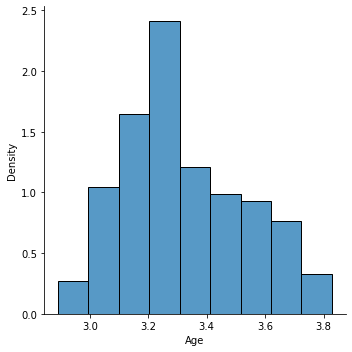

In [9]:
sns.displot(tmp,  stat="density")
plot.show()

In [10]:
def do_test(p_value, alpha = 0.05):
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Принимаем нулевую гипотезу")

In [11]:
W, p = shapiro_test = stats.shapiro(tmp)

In [12]:
do_test(p)

Отвергаем нулевую гипотезу
